In [1]:
%pip install qiskit==3.12.9


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 1.2.3
ERROR: Could not find a version that satisfies the requirement qiskit==3.12.9 (from versions: 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 0.3.8, 0.3.9, 0.3.10, 0.3.11, 0.3.12, 0.3.13, 0.3.14, 0.3.15, 0.3.16, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.15, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.5, 0.5.6, 0.5.7, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.10.4, 0.10.5, 0.11.0, 0.11.1, 0.11.2, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.14.0, 0.14.1, 0.15.0, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.19.5, 0.19.6, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.23.5, 0.23.6, 0.24.0, 0.24.1, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 0.25.4, 0.26.0, 0.26.1, 0.26.2, 0.27.0, 0.28.0, 0.29.0, 0.29.1, 0.30.0, 0.30.1, 0.31.0, 0.32.0, 0.32.1, 0.33.0, 0.33.1, 0

Approach 1 : Classification with EstimatorQNN and PyTorch

In [2]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from matplotlib import pyplot as plt

In [3]:
%pip install time

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for time


In [6]:
%pip install qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 12

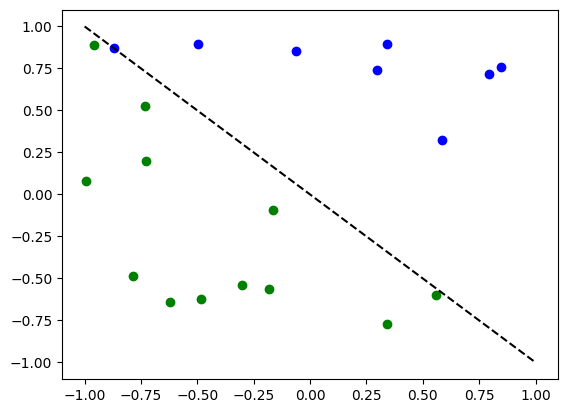

In [5]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [11]:
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
%pip install matplotlib --upgrade


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 1.9 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.1 MB 2.5 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/8.1 MB 2.6 MB/s eta 0:00:03
   ------------ --------------------------- 2.6/8.1 MB 2.8 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 2.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 2.4 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/8.1 MB 2.7 MB/s eta 0:00:02
   ------------------------- -------------- 5.2/8.1 MB 2.8 MB/s eta 0:00:02
   ----------------------------- ---------- 6.0/8.1 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 3.0 MB/s eta 0:00:01
   ------------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\carla\\appdata\\local\\programs\\python\\python312\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
%pip install MatplotlibDrawer

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement MatplotlibDrawer (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for MatplotlibDrawer


In [6]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
print(qc)

     ┌──────────────────────────┐»
q_0: ┤0                         ├»
     │  ZZFeatureMap(x[0],x[1]) │»
q_1: ┤1                         ├»
     └──────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────┐
«q_0: ┤0                                                         ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
«q_1: ┤1                                                         ├
«     └──────────────────────────────────────────────────────────┘


In [7]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [-0.01619859 -0.03522099 -0.06595075  0.05607656  0.08290492  0.04577428
  0.02005696  0.04229077]


C:\Users\Carla\AppData\Local\Temp\ipykernel_9672\3557703904.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn1 = EstimatorQNN(


In [8]:
#single input test
model1(X_[0, :])

tensor([0.2134], grad_fn=<_TorchNNFunctionBackward>)

In [9]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

22.200742721557617
18.387632369995117
20.42877769470215
17.669353485107422
18.422481536865234
17.30420684814453
17.292118072509766
17.288257598876953
17.28681755065918
17.284027099609375
17.28187370300293
17.28176498413086
17.281761169433594
17.281761169433594


tensor(22.2007, grad_fn=<MseLossBackward0>)

Accuracy: 0.65


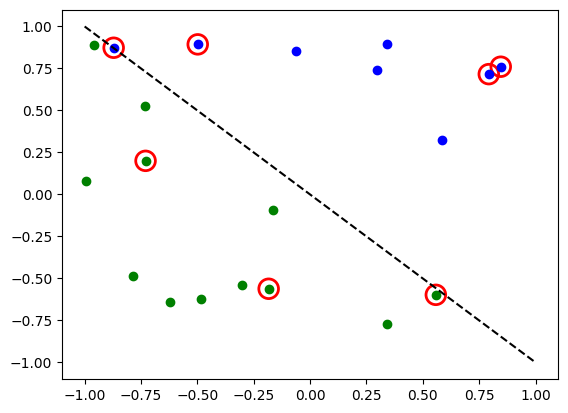

In [10]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Approach 2 : PyTorch and SamplerQNN

In [11]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define SamplerQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)


initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [ 0.00721772  0.01165307  0.08121677 -0.04347192]


C:\Users\Carla\AppData\Local\Temp\ipykernel_9672\1507426735.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn2 = SamplerQNN(


In [12]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method 
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.7136029005050659
0.710931122303009
0.701302170753479
0.6706734895706177
0.7062073349952698
0.7497344613075256
0.7450944781303406
0.6715637445449829
0.6695190668106079
0.6965028047561646
0.664004921913147
0.6632137894630432
0.7404170632362366
0.7444524765014648
0.7567140460014343
0.6485198140144348
0.7232867479324341
0.7422430515289307
0.7563952803611755
0.7074484825134277


Accuracy: 0.65


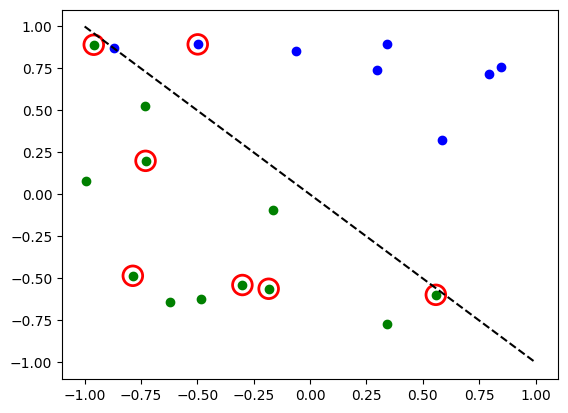

In [13]:
# Evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

MNIST classifier

In [14]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [20]:
# torchvision API to directly load a subset of the MNIST dataset and define torch DataLoaders (link) for train and test.

In [15]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

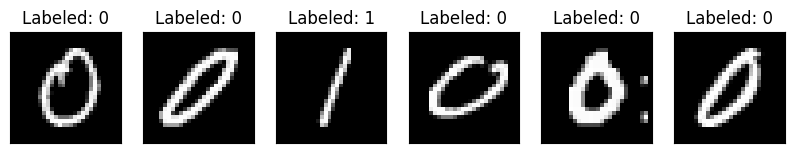

In [17]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [18]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [23]:
#Defining QNN and the Hybrid

In [19]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

C:\Users\Carla\AppData\Local\Temp\ipykernel_9672\2402256359.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [20]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [ ]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.005)
loss_func = NLLLoss()

# Start training
epochs = 60  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [2%]	Loss: -17.8675
Training [3%]	Loss: -18.6318
Training [5%]	Loss: -19.0776
Training [7%]	Loss: -20.0423
Training [8%]	Loss: -21.8782
Training [10%]	Loss: -22.6991
Training [12%]	Loss: -23.0177
Training [13%]	Loss: -23.8807
Training [15%]	Loss: -23.9058
Training [17%]	Loss: -25.6135
Training [18%]	Loss: -27.3809
Training [20%]	Loss: -27.3028
Training [22%]	Loss: -28.4587


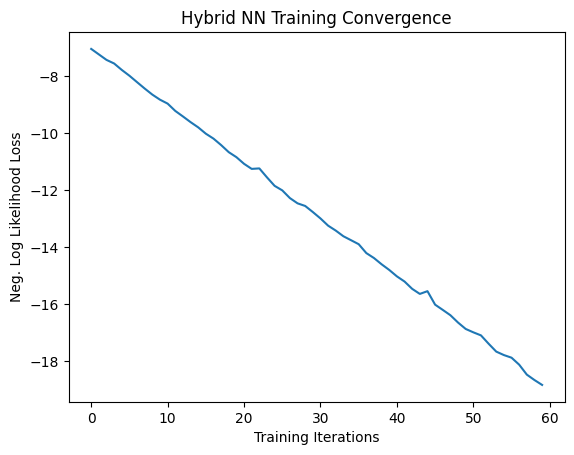

In [24]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [32]:
torch.save(model4.state_dict(), "model4.pt")

In [33]:

# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

C:\Users\Carla\AppData\Local\Temp\ipykernel_21320\2402256359.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Performance on test data:
	Loss: -3.3117
	Accuracy: 100.0%


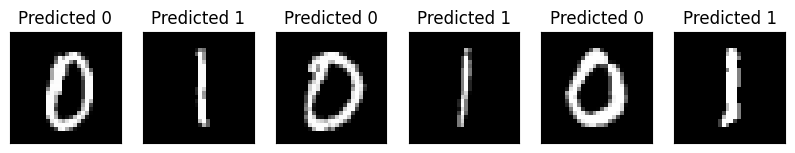

In [34]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

Repeat

In [35]:

# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 5  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Training [20%]	Loss: -3.5048
Training [40%]	Loss: -3.6951
Training [60%]	Loss: -3.9008
Training [80%]	Loss: -4.1158
Training [100%]	Loss: -4.2864


C:\Users\Carla\AppData\Local\Temp\ipykernel_21320\2402256359.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Performance on test data:
	Loss: -3.9914
	Accuracy: 100.0%


In [36]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 5  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Training [20%]	Loss: -4.5150
Training [40%]	Loss: -4.6520
Training [60%]	Loss: -4.9149
Training [80%]	Loss: -5.1208
Training [100%]	Loss: -5.3294


C:\Users\Carla\AppData\Local\Temp\ipykernel_21320\2402256359.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Performance on test data:
	Loss: -4.6867
	Accuracy: 100.0%


In [37]:
print(qc)

     ┌──────────────────────────┐┌──────────────────────────────────────┐
q_0: ┤0                         ├┤0                                     ├
     │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                         ├┤1                                     ├
     └──────────────────────────┘└──────────────────────────────────────┘
